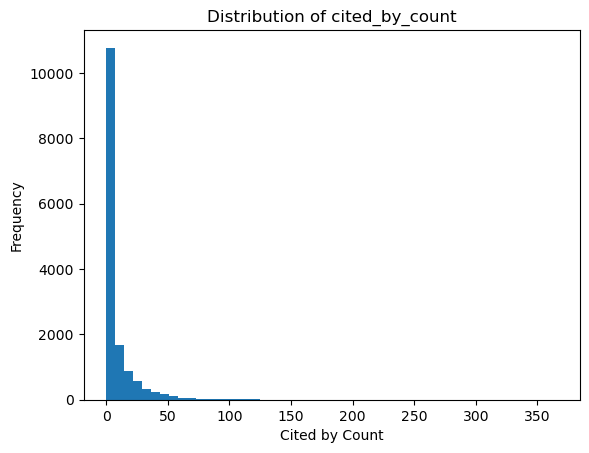

In [6]:
import matplotlib.pyplot as plt
plt.hist(df["cited_by_count"], bins=50)
plt.title("Distribution of cited_by_count")
plt.xlabel("Cited by Count")
plt.ylabel("Frequency")
plt.show()

In [9]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Load the CSV file
file_path = 'data_export.csv'
df = pd.read_csv(file_path)

# Convert relevant columns to numeric and handle missing values
df["author_h_index"] = pd.to_numeric(df["author_h_index"], errors="coerce").fillna(0)
df["journal_h_index"] = pd.to_numeric(df["journal_h_index"], errors="coerce").fillna(0)
df["num_authors"] = pd.to_numeric(df["num_authors"], errors="coerce").fillna(0)
df["num_institutions"] = pd.to_numeric(df["num_institutions"], errors="coerce").fillna(0)
df["cited_by_count"] = pd.to_numeric(df["cited_by_count"], errors="coerce").fillna(0)

# Drop rows where cited_by_count is 0
df = df[df["cited_by_count"] > 0]

# Apply log transformation to cited_by_count
df["log_cited_by_count"] = np.log1p(df["cited_by_count"])  # log(1 + cited_by_count)

# Define independent (X) and dependent (y) variables
X = df[["author_h_index", "journal_h_index", "num_authors", "num_institutions"]]
y = df["log_cited_by_count"]  # Use the log-transformed cited_by_count as y

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     841.9
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        03:30:02   Log-Likelihood:                -12940.
No. Observations:                9862   AIC:                         2.589e+04
Df Residuals:                    9857   BIC:                         2.593e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.2907      0.018  

In [10]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Load the CSV file
file_path = 'data_export.csv'
df = pd.read_csv(file_path)

# Convert relevant columns to numeric and handle missing values
df["author_h_index"] = pd.to_numeric(df["author_h_index"], errors="coerce").fillna(0)
df["journal_h_index"] = pd.to_numeric(df["journal_h_index"], errors="coerce").fillna(0)
df["num_authors"] = pd.to_numeric(df["num_authors"], errors="coerce").fillna(0)
df["num_institutions"] = pd.to_numeric(df["num_institutions"], errors="coerce").fillna(0)
df["cited_by_count"] = pd.to_numeric(df["cited_by_count"], errors="coerce").fillna(0)

# Drop rows where cited_by_count is 0
df = df[df["cited_by_count"] > 0]

# Apply log transformation to cited_by_count
df["log_cited_by_count"] = np.log1p(df["cited_by_count"])  # log(1 + cited_by_count)

# Extract unique predicted_category labels
categories = df["predicted_category"].dropna().unique()

# Initialize a dictionary to store results
category_results = {}

# Run the regression for each category
for category in categories:
    # Filter the data for the current category
    df_category = df[df["predicted_category"] == category]
    
    # Ensure there is enough data to run regression
    if len(df_category) < 2:
        continue  # Skip if there isn't enough data for the category

    # Define independent (X) and dependent (y) variables for the category
    X_cat = df_category[["author_h_index", "journal_h_index", "num_authors", "num_institutions"]]
    y_cat = df_category["log_cited_by_count"]  # Use log-transformed cited_by_count as y

    # Add a constant term to the independent variables
    X_cat = sm.add_constant(X_cat)

    # Fit the OLS regression model
    model_cat = sm.OLS(y_cat, X_cat).fit()

    # Store the summary results
    category_results[category] = model_cat.summary()

# Output the regression summaries for each category
for category, summary in category_results.items():
    print(f"Category: {category}\n")
    print(summary)
    print("\n" + "="*80 + "\n")

Category: Physical Attributes

                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     299.3
Date:                Mon, 30 Dec 2024   Prob (F-statistic):          7.03e-224
Time:                        03:31:15   Log-Likelihood:                -4927.9
No. Observations:                3779   AIC:                             9866.
Df Residuals:                    3774   BIC:                             9897.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const    

In [11]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Load the CSV file
file_path = 'data_export.csv'
df = pd.read_csv(file_path)

# Convert relevant columns to numeric and handle missing values
df["author_h_index"] = pd.to_numeric(df["author_h_index"], errors="coerce").fillna(0)
df["journal_h_index"] = pd.to_numeric(df["journal_h_index"], errors="coerce").fillna(0)
df["num_authors"] = pd.to_numeric(df["num_authors"], errors="coerce").fillna(0)
df["num_institutions"] = pd.to_numeric(df["num_institutions"], errors="coerce").fillna(0)
df["cited_by_count"] = pd.to_numeric(df["cited_by_count"], errors="coerce").fillna(0)

# Drop rows where cited_by_count is 0
df = df[df["cited_by_count"] > 0]

# Apply log transformation to cited_by_count
df["log_cited_by_count"] = np.log1p(df["cited_by_count"])  # log(1 + cited_by_count)

# Extract unique predicted_category labels
categories = df["predicted_category"].dropna().unique()

# Initialize a dictionary to store results
category_results = {}

# Run the regression for each category
for category in categories:
    # Filter the data for the current category
    df_category = df[df["predicted_category"] == category]
    
    # Ensure there is enough data to run regression
    if len(df_category) < 2:
        continue  # Skip if there isn't enough data for the category

    # Define independent (X) and dependent (y) variables for the category
    X_cat = df_category[["author_h_index", "journal_h_index", "num_authors", "num_institutions"]]
    y_cat = df_category["log_cited_by_count"]  # Use log-transformed cited_by_count as y

    # Add a constant term to the independent variables
    X_cat = sm.add_constant(X_cat)

    # Fit the OLS regression model
    model_cat = sm.OLS(y_cat, X_cat).fit()

    # Store the regression results
    category_results[category] = model_cat

# Prepare a correctly formatted and rounded summary for each category
formatted_summary = []

for category, results in category_results.items():
    # Extract coefficients and p-values from the regression model
    coefficients = results.params
    p_values = results.pvalues

    # Format the output for each variable
    formatted_summary.append({
        "Category": category,
        "const": f"{coefficients['const']:.2f} ({p_values['const']:.2f}{'*' if p_values['const'] < 0.05 else ''})",
        "author_h_index": f"{coefficients['author_h_index']:.2f} ({p_values['author_h_index']:.2f}{'*' if p_values['author_h_index'] < 0.05 else ''})",
        "journal_h_index": f"{coefficients['journal_h_index']:.2f} ({p_values['journal_h_index']:.2f}{'*' if p_values['journal_h_index'] < 0.05 else ''})",
        "num_authors": f"{coefficients['num_authors']:.2f} ({p_values['num_authors']:.2f}{'*' if p_values['num_authors'] < 0.05 else ''})",
        "num_institutions": f"{coefficients['num_institutions']:.2f} ({p_values['num_institutions']:.2f}{'*' if p_values['num_institutions'] < 0.05 else ''})"
    })

# Convert the formatted summary to a DataFrame
summary_df_final = pd.DataFrame(formatted_summary)

# Display the formatted table
print(summary_df_final)

                  Category         const author_h_index journal_h_index  \
0      Physical Attributes  1.26 (0.00*)   0.05 (0.00*)    0.01 (0.00*)   
1         Tactics analysis  1.38 (0.00*)   0.05 (0.00*)    0.01 (0.00*)   
2       Medical / Injuries  1.25 (0.00*)   0.07 (0.00*)    0.01 (0.00*)   
3               Psychology  1.20 (0.00*)   0.06 (0.00*)    0.01 (0.00*)   
4  Innovative Technologies  1.19 (0.00*)   0.09 (0.00*)    0.00 (0.00*)   
5       Scouting / Finance  1.23 (0.00*)   0.09 (0.00*)    0.01 (0.00*)   
6                    Other  1.13 (0.00*)   0.09 (0.00*)    0.00 (0.02*)   

    num_authors num_institutions  
0  0.05 (0.00*)     -0.01 (0.12)  
1   0.03 (0.08)     -0.00 (0.98)  
2  0.03 (0.00*)     -0.01 (0.40)  
3  0.07 (0.00*)     -0.04 (0.07)  
4  0.05 (0.00*)      0.01 (0.55)  
5   0.02 (0.28)      0.01 (0.81)  
6   0.03 (0.25)     0.07 (0.03*)  


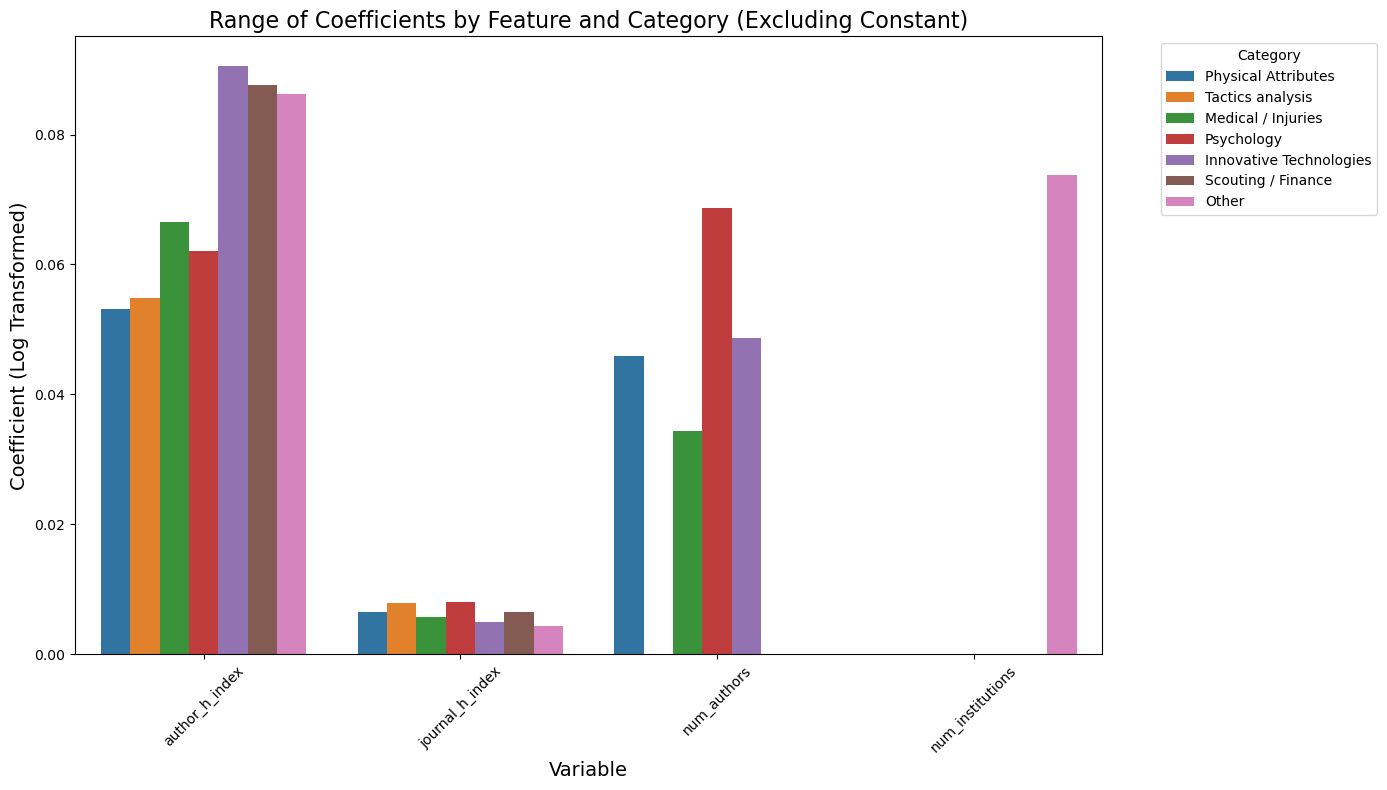

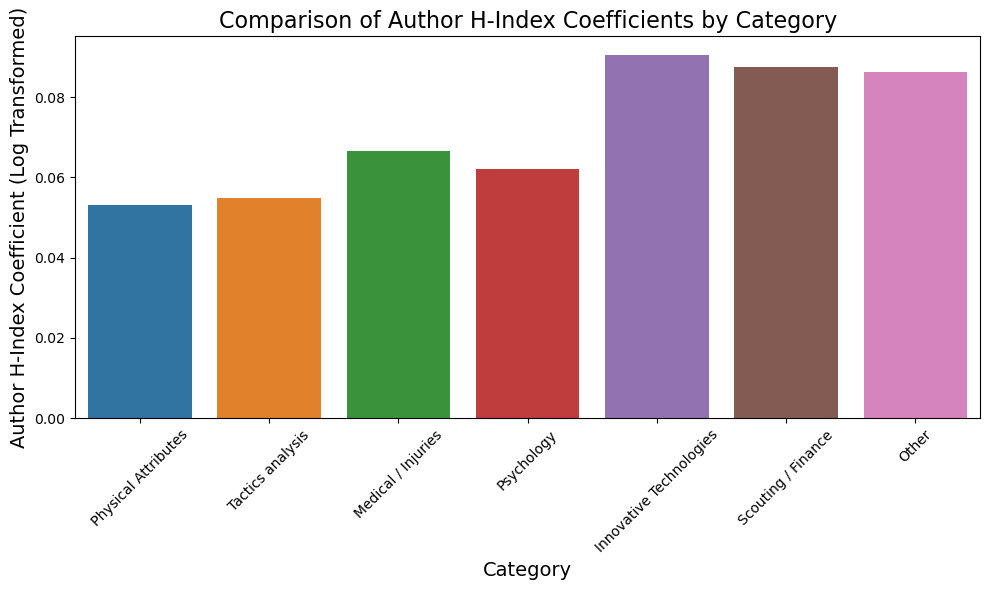

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare a DataFrame for visualization from category_results
visualization_data = []

for category, results in category_results.items():
    coefficients = results.params
    p_values = results.pvalues
    
    for var in coefficients.index:
        visualization_data.append({
            "Category": category,
            "Variable": var,
            "Coefficient": coefficients[var],
            "Significant": p_values[var] < 0.05  # Flag for statistical significance
        })

# Convert to a DataFrame
coef_melted_with_significance = pd.DataFrame(visualization_data)

# Exclude the constant ('const') coefficients
coef_melted_no_const = coef_melted_with_significance[coef_melted_with_significance["Variable"] != "const"]

# Filter only significant data
significant_data = coef_melted_no_const[coef_melted_no_const["Significant"]]

# Plot the range of coefficients for all features excluding 'const'
plt.figure(figsize=(14, 8))

# Plot only significant coefficients with distinct colors
sns.barplot(
    data=significant_data,
    x="Variable",
    y="Coefficient",
    hue="Category",  # Explicitly set hue
    dodge=True,
    palette="tab10"  # Restore color palette for significant coefficients
)

# Title and labels
plt.title("Range of Coefficients by Feature and Category (Excluding Constant)", fontsize=16)
plt.xlabel("Variable", fontsize=14)
plt.ylabel("Coefficient (Log Transformed)", fontsize=14)  # Adjust label to reflect log-transformed y
plt.xticks(rotation=45)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

# Focused comparison for author H-index coefficients
author_h_index_data = significant_data[significant_data["Variable"] == "author_h_index"]

plt.figure(figsize=(10, 6))

# Plot only significant coefficients for author H-index
sns.barplot(
    data=author_h_index_data,
    x="Category",
    y="Coefficient",
    hue="Category",  # Explicitly set hue
    dodge=False,
    palette="tab10"  # Restore colors for significant coefficients
)

# Title and labels
plt.title("Comparison of Author H-Index Coefficients by Category", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Author H-Index Coefficient (Log Transformed)", fontsize=14)  # Adjust label
plt.xticks(rotation=45)
plt.legend([], [], frameon=False)  # Remove redundant legend
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from collections import defaultdict
import ast

# Load the CSV file
file_path = 'data_export.csv'
df = pd.read_csv(file_path)

# Convert relevant columns to numeric and handle missing values
df["author_h_index"] = pd.to_numeric(df["author_h_index"], errors="coerce").fillna(0)
df["journal_h_index"] = pd.to_numeric(df["journal_h_index"], errors="coerce").fillna(0)
df["num_authors"] = pd.to_numeric(df["num_authors"], errors="coerce").fillna(0)
df["num_institutions"] = pd.to_numeric(df["num_institutions"], errors="coerce").fillna(0)
df["cited_by_count"] = pd.to_numeric(df["cited_by_count"], errors="coerce").fillna(0)

# Drop rows where cited_by_count is 0
df = df[df["cited_by_count"] > 0]

# Apply log transformation to cited_by_count
df["log_cited_by_count"] = np.log1p(df["cited_by_count"])  # log(1 + cited_by_count)

# Default dictionaries to track publication and citation counts
author_publications = defaultdict(int)
author_citations = defaultdict(int)

# Calculate total publications and citations for each author
for _, row in df.iterrows():
    if pd.notna(row["authors"]):  # Process the "authors" field
        # Parse the authors list
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        # Increment publication count and citations for each author
        for author in authors:
            author_publications[author] += 1
            author_citations[author] += row.get("cited_by_count", 0)

# Function to calculate average co-author citations
def calculate_coauthor_success(row):
    if pd.notna(row["authors"]):
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        coauthor_citations = [author_citations[author] for author in authors if author in author_citations]
        if coauthor_citations:
            return sum(coauthor_citations) / len(coauthor_citations)
    return 0

# Add average co-author citations as a feature
df["avg_coauthor_citations"] = df.apply(calculate_coauthor_success, axis=1)

# Log-transform the average co-author citations to reduce skewness
df["log_avg_coauthor_citations"] = np.log1p(df["avg_coauthor_citations"])  # log(1 + avg_coauthor_citations)

# Define independent (X) and dependent (y) variables
X = df[["log_avg_coauthor_citations", "journal_h_index", "num_authors", "num_institutions"]]
y = df["log_cited_by_count"]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     1128.
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        03:58:11   Log-Likelihood:                -12157.
No. Observations:                9862   AIC:                         2.433e+04
Df Residuals:                    9856   BIC:                         2.437e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [18]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from collections import defaultdict
import ast

# Load the CSV file
file_path = 'data_export.csv'
df = pd.read_csv(file_path)

# Convert relevant columns to numeric and handle missing values
df["author_h_index"] = pd.to_numeric(df["author_h_index"], errors="coerce").fillna(0)
df["journal_h_index"] = pd.to_numeric(df["journal_h_index"], errors="coerce").fillna(0)
df["num_authors"] = pd.to_numeric(df["num_authors"], errors="coerce").fillna(0)
df["num_institutions"] = pd.to_numeric(df["num_institutions"], errors="coerce").fillna(0)
df["cited_by_count"] = pd.to_numeric(df["cited_by_count"], errors="coerce").fillna(0)
df["publication_year"] = pd.to_numeric(df["publication_year"], errors="coerce").fillna(2024)

# Drop rows where cited_by_count is 0
df = df[df["cited_by_count"] > 0]

# Apply log transformation to cited_by_count
df["log_cited_by_count"] = np.log1p(df["cited_by_count"])  # log(1 + cited_by_count)

# Calculate time since publication
df["years_since_publication"] = 2024 - df["publication_year"]

# Default dictionaries to track publication and citation counts
author_publications = defaultdict(int)
author_citations = defaultdict(int)

# Calculate total publications and citations for each author
for _, row in df.iterrows():
    if pd.notna(row["authors"]):  # Process the "authors" field
        # Parse the authors list
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        # Increment publication count and citations for each author
        for author in authors:
            author_publications[author] += 1
            author_citations[author] += row.get("cited_by_count", 0)

# Function to calculate average co-author citations
def calculate_coauthor_success(row):
    if pd.notna(row["authors"]):
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        coauthor_citations = [author_citations[author] for author in authors if author in author_citations]
        if coauthor_citations:
            return sum(coauthor_citations) / len(coauthor_citations)
    return 0

# Add average co-author citations as a feature
df["avg_coauthor_citations"] = df.apply(calculate_coauthor_success, axis=1)

# Log-transform the average co-author citations to reduce skewness
df["log_avg_coauthor_citations"] = np.log1p(df["avg_coauthor_citations"])  # log(1 + avg_coauthor_citations)

# Define independent (X) and dependent (y) variables
X = df[[
    "log_avg_coauthor_citations", 
    "years_since_publication",  # Include time since publication
    "journal_h_index", 
    "num_authors", 
    "num_institutions"
]]
y = df["log_cited_by_count"]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     1954.
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        04:07:01   Log-Likelihood:                -10992.
No. Observations:                9862   AIC:                         2.200e+04
Df Residuals:                    9856   BIC:                         2.204e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [31]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from collections import defaultdict
import ast

# Load the CSV file
file_path = 'data_export.csv'
df = pd.read_csv(file_path)

# Convert relevant columns to numeric and handle missing values
df["author_h_index"] = pd.to_numeric(df["author_h_index"], errors="coerce").fillna(0)
df["journal_h_index"] = pd.to_numeric(df["journal_h_index"], errors="coerce").fillna(0)
df["num_authors"] = pd.to_numeric(df["num_authors"], errors="coerce").fillna(0)
df["num_institutions"] = pd.to_numeric(df["num_institutions"], errors="coerce").fillna(0)
df["cited_by_count"] = pd.to_numeric(df["cited_by_count"], errors="coerce").fillna(0)
df["publication_year"] = pd.to_numeric(df["publication_year"], errors="coerce").fillna(2024)

# Drop rows where cited_by_count is 0
#df = df[df["cited_by_count"] > 0]

# Apply log transformation to cited_by_count
df["log_cited_by_count"] = np.log1p(df["cited_by_count"])  # log(1 + cited_by_count)

# Calculate time since publication
df["years_since_publication"] = 2024 - df["publication_year"]

# Default dictionaries to track publication and citation counts
author_publications = defaultdict(int)
author_citations = defaultdict(int)

# Calculate total publications and citations for each author
for _, row in df.iterrows():
    if pd.notna(row["authors"]):  # Process the "authors" field
        # Parse the authors list
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        # Increment publication count and citations for each author
        for author in authors:
            author_publications[author] += 1
            author_citations[author] += row.get("cited_by_count", 0)

# Function to calculate average co-author citations excluding the focal paper
def calculate_coauthor_success(row):
    if pd.notna(row["authors"]):
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        coauthor_citations = [
            author_citations[author] - row["cited_by_count"]  # Exclude focal paper's citations
            for author in authors if author in author_citations
        ]
        if coauthor_citations:
            return sum(coauthor_citations) / len(coauthor_citations)
    return 0

# Add average co-author citations as a feature
df["avg_coauthor_citations"] = df.apply(calculate_coauthor_success, axis=1)

# Log-transform the average co-author citations to reduce skewness
df["log_avg_coauthor_citations"] = np.log1p(df["avg_coauthor_citations"])  # log(1 + avg_coauthor_citations)

# Define independent (X) and dependent (y) variables
X = df[[
    "log_avg_coauthor_citations", 
    "years_since_publication",  # Include time since publication
    "journal_h_index", 
    "num_authors", 
    "num_institutions"
]]
y = df["log_cited_by_count"]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     2119.
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:29:33   Log-Likelihood:                -21037.
No. Observations:               15033   AIC:                         4.209e+04
Df Residuals:                   15027   BIC:                         4.213e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [20]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from collections import defaultdict
import ast

# Load the CSV file
file_path = 'data_export.csv'
df = pd.read_csv(file_path)

# Convert relevant columns to numeric and handle missing values
df["author_h_index"] = pd.to_numeric(df["author_h_index"], errors="coerce").fillna(0)
df["journal_h_index"] = pd.to_numeric(df["journal_h_index"], errors="coerce").fillna(0)
df["num_authors"] = pd.to_numeric(df["num_authors"], errors="coerce").fillna(0)
df["num_institutions"] = pd.to_numeric(df["num_institutions"], errors="coerce").fillna(0)
df["cited_by_count"] = pd.to_numeric(df["cited_by_count"], errors="coerce").fillna(0)
df["publication_year"] = pd.to_numeric(df["publication_year"], errors="coerce").fillna(2024)

# Drop rows where cited_by_count is 0
#df = df[df["cited_by_count"] > 0]

# Apply log transformation to cited_by_count
df["log_cited_by_count"] = np.log1p(df["cited_by_count"])  # log(1 + cited_by_count)

# Calculate time since publication
df["years_since_publication"] = 2024 - df["publication_year"]

# Default dictionaries to track publication and citation counts
author_publications = defaultdict(int)
author_citations = defaultdict(int)

# Calculate total publications and citations for each author
for _, row in df.iterrows():
    if pd.notna(row["authors"]):  # Process the "authors" field
        # Parse the authors list
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        # Increment publication count and citations for each author
        for author in authors:
            author_publications[author] += 1
            author_citations[author] += row.get("cited_by_count", 0)

# Function to calculate average co-author citations
def calculate_coauthor_success(row):
    if pd.notna(row["authors"]):
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        coauthor_citations = [author_citations[author] for author in authors if author in author_citations]
        if coauthor_citations:
            return sum(coauthor_citations) / len(coauthor_citations)
    return 0

# Add average co-author citations as a feature
df["avg_coauthor_citations"] = df.apply(calculate_coauthor_success, axis=1)

# Log-transform the average co-author citations to reduce skewness
df["log_avg_coauthor_citations"] = np.log1p(df["avg_coauthor_citations"])  # log(1 + avg_coauthor_citations)

# Extract unique predicted_category labels
categories = df["predicted_category"].dropna().unique()

# Initialize a dictionary to store results
category_results = {}

# Run the regression for each category
for category in categories:
    # Filter the data for the current category
    df_category = df[df["predicted_category"] == category]
    
    # Ensure there is enough data to run regression
    if len(df_category) < 2:
        continue  # Skip if there isn't enough data for the category

    # Define independent (X) and dependent (y) variables for the category
    X_cat = df_category[[
        "log_avg_coauthor_citations", 
        "years_since_publication", 
        "journal_h_index", 
        "num_authors", 
        "num_institutions"
    ]]
    y_cat = df_category["log_cited_by_count"]

    # Add a constant term to the independent variables
    X_cat = sm.add_constant(X_cat)

    # Fit the OLS regression model
    model_cat = sm.OLS(y_cat, X_cat).fit()

    # Store the regression results
    category_results[category] = model_cat

# Output the regression summaries for each category
for category, results in category_results.items():
    print(f"Category: {category}\n")
    print(results.summary())
    print("\n" + "="*80 + "\n")

Category: Physical Attributes

                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     1309.
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        04:12:33   Log-Likelihood:                -7050.4
No. Observations:                5504   AIC:                         1.411e+04
Df Residuals:                    5498   BIC:                         1.415e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [32]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from collections import defaultdict
import ast

# Load the CSV file
file_path = 'data_export.csv'
df = pd.read_csv(file_path)

# Convert relevant columns to numeric and handle missing values
df["author_h_index"] = pd.to_numeric(df["author_h_index"], errors="coerce").fillna(0)
df["journal_h_index"] = pd.to_numeric(df["journal_h_index"], errors="coerce").fillna(0)
df["num_authors"] = pd.to_numeric(df["num_authors"], errors="coerce").fillna(0)
df["num_institutions"] = pd.to_numeric(df["num_institutions"], errors="coerce").fillna(0)
df["cited_by_count"] = pd.to_numeric(df["cited_by_count"], errors="coerce").fillna(0)
df["publication_year"] = pd.to_numeric(df["publication_year"], errors="coerce").fillna(2024)

# Drop rows where cited_by_count is 0
#df = df[df["cited_by_count"] > 0]

# Apply log transformation to cited_by_count
df["log_cited_by_count"] = np.log1p(df["cited_by_count"])  # log(1 + cited_by_count)

# Calculate time since publication
df["years_since_publication"] = 2024 - df["publication_year"]

# Default dictionaries to track publication and citation counts
author_publications = defaultdict(int)
author_citations = defaultdict(int)

# Calculate total publications and citations for each author
for _, row in df.iterrows():
    if pd.notna(row["authors"]):  # Process the "authors" field
        # Parse the authors list
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        # Increment publication count and citations for each author
        for author in authors:
            author_publications[author] += 1
            author_citations[author] += row.get("cited_by_count", 0)

# Function to calculate average co-author citations excluding the focal paper
def calculate_coauthor_success(row):
    if pd.notna(row["authors"]):
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        coauthor_citations = [
            author_citations[author] - row["cited_by_count"]  # Exclude focal paper's citations
            for author in authors if author in author_citations
        ]
        if coauthor_citations:
            return sum(coauthor_citations) / len(coauthor_citations)
    return 0

# Add average co-author citations as a feature
df["avg_coauthor_citations"] = df.apply(calculate_coauthor_success, axis=1)

# Log-transform the average co-author citations to reduce skewness
df["log_avg_coauthor_citations"] = np.log1p(df["avg_coauthor_citations"])  # log(1 + avg_coauthor_citations)

# Extract unique predicted_category labels
categories = df["predicted_category"].dropna().unique()

# Initialize a dictionary to store results
category_results = {}

# Run the regression for each category
for category in categories:
    # Filter the data for the current category
    df_category = df[df["predicted_category"] == category]
    
    # Ensure there is enough data to run regression
    if len(df_category) < 2:
        continue  # Skip if there isn't enough data for the category

    # Define independent (X) and dependent (y) variables for the category
    X_cat = df_category[[
        "log_avg_coauthor_citations", 
        "years_since_publication", 
        "journal_h_index", 
        "num_authors", 
        "num_institutions"
    ]]
    y_cat = df_category["log_cited_by_count"]

    # Add a constant term to the independent variables
    X_cat = sm.add_constant(X_cat)

    # Fit the OLS regression model
    model_cat = sm.OLS(y_cat, X_cat).fit()

    # Store the regression results
    category_results[category] = model_cat

# Output the regression summaries for each category
for category, results in category_results.items():
    print(f"Category: {category}\n")
    print(results.summary())
    print("\n" + "="*80 + "\n")

Category: Physical Attributes

                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     939.1
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:31:58   Log-Likelihood:                -7509.7
No. Observations:                5504   AIC:                         1.503e+04
Df Residuals:                    5498   BIC:                         1.507e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

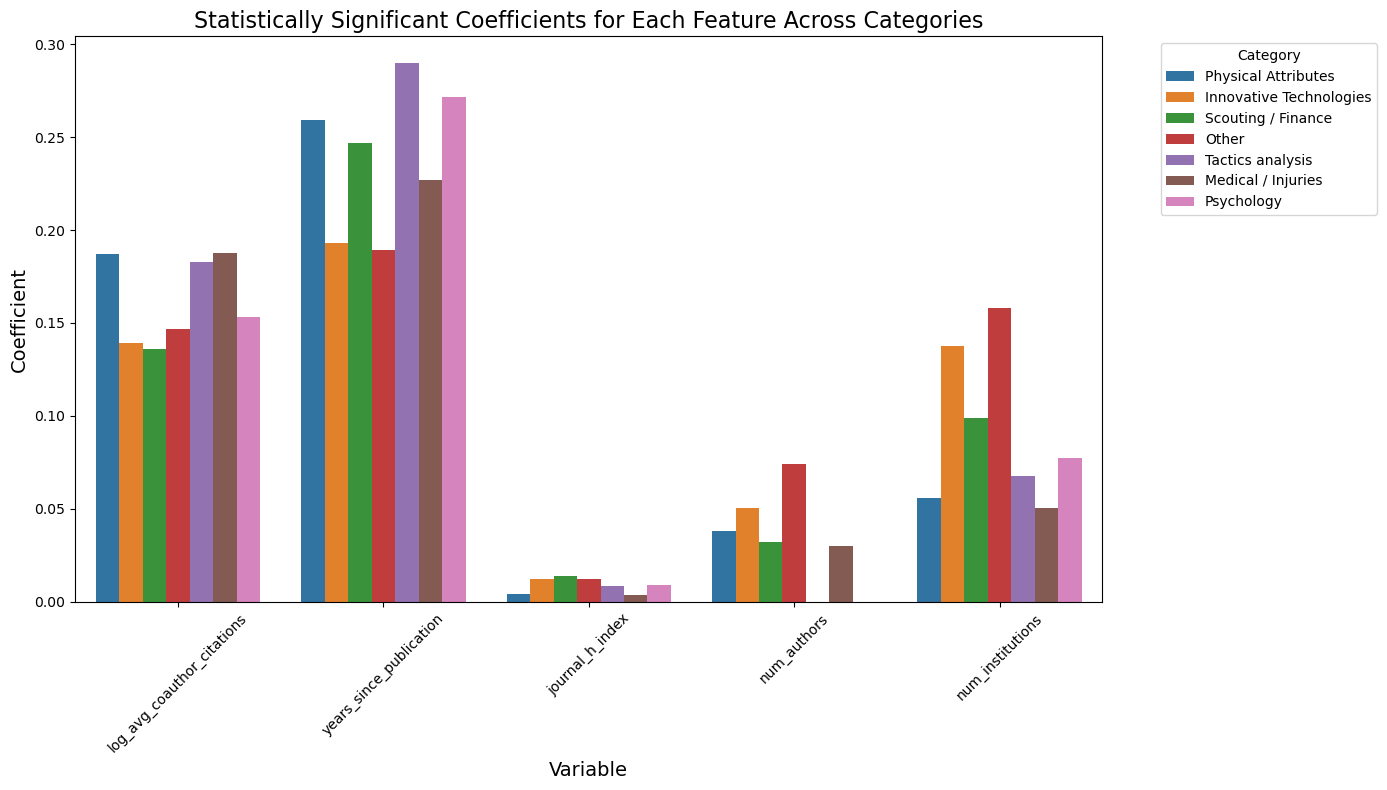

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare a DataFrame for visualization from category_results
visualization_data = []

# Iterate over category_results to extract coefficients and significance
for category, results in category_results.items():
    for variable in ["log_avg_coauthor_citations", "years_since_publication", "journal_h_index", "num_authors", "num_institutions"]:
        coef = results.params.get(variable, 0)  # Extract coefficient
        p_value = results.pvalues.get(variable, 1)  # Extract p-value
        is_significant = p_value < 0.05  # Check if p-value indicates significance

        # Append only significant coefficients
        if is_significant:
            visualization_data.append({
                "Category": category,
                "Variable": variable,
                "Coefficient": coef
            })

# Convert to DataFrame for plotting
coef_melted_with_significance = pd.DataFrame(visualization_data)

# Plot only significant coefficients
plt.figure(figsize=(14, 8))

sns.barplot(
    data=coef_melted_with_significance,
    x="Variable",
    y="Coefficient",
    hue="Category",
    dodge=True,
    palette="tab10"  # Use distinct colors for categories
)

# Title and labels
plt.title("Statistically Significant Coefficients for Each Feature Across Categories", fontsize=16)
plt.xlabel("Variable", fontsize=14)
plt.ylabel("Coefficient", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define the independent variables (X)
X = df[[
    "log_avg_coauthor_citations", 
    "years_since_publication", 
    "journal_h_index", 
    "num_authors", 
    "num_institutions"
]]
X = sm.add_constant(X)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                     Variable       VIF
0                       const  5.834355
1  log_avg_coauthor_citations  1.423196
2     years_since_publication  1.022684
3             journal_h_index  1.273489
4                 num_authors  1.683645
5            num_institutions  1.768360


In [45]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from collections import defaultdict
import ast

# Load the CSV file
file_path = 'data_export.csv'
df = pd.read_csv(file_path)

# Convert relevant columns to numeric and handle missing values
fields_to_convert = [
    "journal_h_index", "num_authors", "num_institutions",
    "cited_by_count", "publication_year", "avg_author_h_index", "max_author_h_index",
    "avg_institution_h_index", "max_institution_h_index", "avg_author_citations_past_5_years",
    "max_author_citations_past_5_years", "avg_institution_citations_past_5_years", 
    "max_institution_citations_past_5_years"
]
for field in fields_to_convert:
    df[field] = pd.to_numeric(df[field], errors="coerce").fillna(0)

# Drop rows where cited_by_count is 0
#df = df[df["cited_by_count"] > 0]

# Apply log transformation to cited_by_count
df["log_cited_by_count"] = np.log1p(df["cited_by_count"])  # log(1 + cited_by_count)

# Calculate time since publication
df["years_since_publication"] = 2024 - df["publication_year"]

# Default dictionaries to track publication and citation counts
author_publications = defaultdict(int)
author_citations = defaultdict(int)

# Calculate total publications and citations for each author
for _, row in df.iterrows():
    if pd.notna(row["authors"]):  # Process the "authors" field
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        for author in authors:
            author_publications[author] += 1
            author_citations[author] += row.get("cited_by_count", 0)

# Function to calculate average co-author citations excluding the focal paper
def calculate_coauthor_success(row):
    if pd.notna(row["authors"]):
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        coauthor_citations = [
            author_citations[author] - row["cited_by_count"]  # Exclude focal paper's citations
            for author in authors if author in author_citations
        ]
        if coauthor_citations:
            return sum(coauthor_citations) / len(coauthor_citations)
    return 0

# Add average co-author citations as a feature
df["avg_coauthor_citations"] = df.apply(calculate_coauthor_success, axis=1)

# Log-transform the average co-author citations to reduce skewness
df["log_avg_coauthor_citations"] = np.log1p(df["avg_coauthor_citations"])  # log(1 + avg_coauthor_citations)

# Define independent (X) and dependent (y) variables
X = df[[
    #"log_avg_coauthor_citations", 
    "years_since_publication", 
    "journal_h_index", 
    "num_authors", 
    "num_institutions", 
    "avg_author_citations_past_5_years",
    "max_author_citations_past_5_years",
    "avg_institution_citations_past_5_years",
    "max_institution_citations_past_5_years"
]]
y = df["log_cited_by_count"]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     1230.
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:54:25   Log-Likelihood:                -21261.
No. Observations:               15033   AIC:                         4.254e+04
Df Residuals:                   15024   BIC:                         4.261e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 1: Define independent (X) and dependent (y) variables
X = df[[
    "log_avg_coauthor_citations", 
    "years_since_publication", 
    "journal_h_index", 
    "num_authors", 
    "num_institutions", 
    "avg_author_citations_past_5_years",
    "max_author_citations_past_5_years",
    "avg_institution_citations_past_5_years",
    "max_institution_citations_past_5_years"
]]
y = df["log_cited_by_count"]

# Add a constant term
X = sm.add_constant(X)

# Step 2: Calculate VIF and remove high VIF features iteratively
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Initial VIF calculation
vif_data = calculate_vif(X)

# Iteratively drop variables with high VIF
while vif_data["VIF"].max() > 5:  # You can change the threshold to 10 if appropriate
    high_vif_variable = vif_data.loc[vif_data["VIF"].idxmax(), "Variable"]
    if high_vif_variable == "const":
        break  # Do not drop the constant term
    print(f"Dropping {high_vif_variable} due to high VIF ({vif_data['VIF'].max():.2f})")
    X = X.drop(columns=[high_vif_variable])
    vif_data = calculate_vif(X)

# Step 3: Fit the OLS regression model with the reduced set of variables
model = sm.OLS(y, X).fit()

# Print the summary of the improved regression model
print(model.summary())

# Step 4: Recalculate VIF for the reduced model
vif_data_final = calculate_vif(X)
print("Final VIF values:")
print(vif_data_final)

# Step 5: Analyze the new model

                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     509.2
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:50:19   Log-Likelihood:                -11854.
No. Observations:                9862   AIC:                         2.374e+04
Df Residuals:                    9848   BIC:                         2.384e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------